## Import Basic Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings as warn

from numpy import arange
%matplotlib inline
warn.filterwarnings('ignore')

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

CONSTANT_SEED = 100

## Set Up Imported Data Set

In [2]:
main_heart_df = pd.read_csv('heart.csv')
main_heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [3]:
# delete a single row by index value 449 - As shown in EDA
main_heart_df = main_heart_df.drop(labels=449, axis=0).reset_index(drop=True)

## Most Important features

1) ChestPainType_ASY 

2) Sex_F 

3) Oldpeak 

4) ExerciseAngina_N 

5) ST_Slope_Up

## Process for Decision Tree

In [5]:
def Best_Decision_Tree_Model_process(name_df):
    # One hot implementation
    ohe = OneHotEncoder()

    # Select the categorical columns to encode
    cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

    # Fit the encoder on the selected categorical columns
    ohe.fit(name_df[cat_cols])

    # One-hot encode the selected categorical columns
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df[cat_cols]).toarray(),
                                   columns=ohe.get_feature_names_out(cat_cols))

    # Select the numeric columns to keep
    num_cols = ['Oldpeak']

    # Select the binary columns to keep
    bin_cols = ['ChestPainType_ASY', 'Sex_F', 'ST_Slope_Up' , 'ExerciseAngina_N']
    

    # Combine the selected columns into a final DataFrame
    name_df_selected = pd.concat([name_df[num_cols], name_df_cat_ohe[bin_cols], name_df['HeartDisease']],
                                 sort = False, axis = 1).reindex(index=name_df[num_cols].index)

    # Check the final dataframe
    name_df_selected.info()
    
    print('')


    # Extract Response and Predictors
    y = pd.DataFrame(name_df_selected['HeartDisease'])
    X = pd.DataFrame(name_df_selected.drop('HeartDisease', axis = 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)
    
    # Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
    from sklearn.model_selection import GridSearchCV

    # Define the Hyper-parameter Grid to search on, in case of Multi-Variate Classification Tree
    param_grid = {'max_depth': np.arange(2, 10)}             # depth of trees 2, 3, 4, 5, ..., 11

    # Create the Hyper-parameter Grid
    hpGrid = GridSearchCV(DecisionTreeClassifier(random_state = CONSTANT_SEED),   # the model family
                      param_grid,                 # the search grid
                      cv=5,                       # 5-fold cross-validation
                      scoring='f1',               # score to evaluate
                      )     

    # Train the models using Cross-Validation
    hpGrid.fit(X_train, y_train.HeartDisease.ravel())
    
    # Fetch the best Model or the best set of Hyper-parameters
    print(hpGrid.best_estimator_)
    
    print('')
    
    # Print the score (accuracy) of the best Model after CV
    print(np.abs(hpGrid.best_score_))

    # get the best parameter
    best_para = hpGrid.best_estimator_
    
    # Decision Tree using Train Data
    best_dectree = hpGrid.best_estimator_
    best_dectree.fit(X_train, y_train)

    # Predict the Response corresponding to Predictors
    y_train_pred = best_dectree.predict(X_train)

    # Predict the Response corresponding to Predictors
    y_test_pred = best_dectree.predict(X_test)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])
    plt.show()
    
    #Predict the Response corresponding to Predictors
    y_train_pred = hpGrid.best_estimator_.predict(X_train)

    #Print the Classification Accuracy
    print("Train Data")
    print(classification_report(y_train,y_train_pred))
    print()

    print('---------------------------------------------')

    #Predict the Response corresponding to Predictors
    y_test_pred = hpGrid.best_estimator_.predict(X_test)

    #Print the Classification Accuracy
    print("Test Data")
    print(classification_report(y_test,y_test_pred))
    print()
    
    
    # Import the necessary library for ROC-AUC curve
    from sklearn.metrics import roc_curve, roc_auc_score

    # Get the predicted probabilities for the test set
    y_score = best_dectree.predict_proba(X_test)[:, 1]

    # Calculate the ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_score)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print("ROC-AUC Score:", roc_auc)

## Process for Random Forest

In [6]:
def Best_Random_Forest_Model_process(name_df):
    # One hot implementation
    ohe = OneHotEncoder()

    # Select the categorical columns to encode
    cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

    # Fit the encoder on the selected categorical columns
    ohe.fit(name_df[cat_cols])

    # One-hot encode the selected categorical columns
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df[cat_cols]).toarray(),
                                   columns=ohe.get_feature_names_out(cat_cols))

    # Select the numeric columns to keep
    num_cols = ['Oldpeak']

    # Select the binary columns to keep
    bin_cols = ['ChestPainType_ASY', 'Sex_F', 'ST_Slope_Up' , 'ExerciseAngina_N']
    

    # Combine the selected columns into a final DataFrame
    name_df_selected = pd.concat([name_df[num_cols], name_df_cat_ohe[bin_cols], name_df['HeartDisease']],
                                 sort = False, axis = 1).reindex(index=name_df[num_cols].index)

    # Check the final dataframe
    name_df_selected.info()
    
    print('')
    
    # Extract Response and Predictors
    y = pd.DataFrame(name_df_selected['HeartDisease'])
    X = pd.DataFrame(name_df_selected.drop('HeartDisease', axis = 1))

    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)

    # Define the Hyper-parameter Grid to search on, in case of Random Forest
    param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
                  'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

    # Create the Hyper-parameter Grid
    hpGrid = GridSearchCV(RandomForestClassifier(random_state = CONSTANT_SEED),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'f1')       # score to evaluate

    # Train the models using Cross-Validation
    hpGrid.fit(X_train, y_train.HeartDisease.ravel())

    # Fetch the best Model or the best set of Hyper-parameters
    print("Best estimator for Number of Trees:\t", hpGrid.best_estimator_.n_estimators)
    print("Best estimator for Max Depth:\t\t", hpGrid.best_estimator_.max_depth)

    # Print the score (accuracy) of the best Model after CV
    print(np.abs(hpGrid.best_score_))
    
    
    #////////////////////////////////////#
    

    # Create the Random Forest object
    rforest = RandomForestClassifier(n_estimators = hpGrid.best_estimator_.n_estimators,  # n_estimators denote number of trees
                                     max_depth =  hpGrid.best_estimator_.max_depth,     # set the maximum depth of each tree
                                     random_state = CONSTANT_SEED)       

    # Fit Random Forest on Train Data
    rforest.fit(X_train, y_train.HeartDisease.ravel())

    # Predict the Response corresponding to Predictors
    y_train_pred = rforest.predict(X_train)
    
    # Predict the Response corresponding to Predictors
    y_test_pred = rforest.predict(X_test)
    
    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1 = sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
    ax1.set_title("Confusion Matrix for Training Data")
    
    ax2 = sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])
    ax2.set_title("Confusion Matrix for Test Data")
    plt.show()

    # Print the Classification Report
    print("Classification Report\n")
    print("Train Data")
    print(classification_report(y_train,y_train_pred))
    print('---------------------------------------------')
    print()
    # Print the Classification Accuracy
    print("Test Data")
    print(classification_report(y_test,y_test_pred))
    print()
    
    # Get decision scores for the test set
    y_score = rforest.predict_proba(X_test)[:, 1]

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_score)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print("ROC-AUC Score:", roc_auc)
    

## Process for Logistic Regression 

In [7]:
def Best_Logistic_Regression_model_process(name_df):
    #One hot implementation
    ohe = OneHotEncoder()

    # OneHotEncoding of categorical predictors (not the response)
    name_df_cat = name_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
    ohe.fit(name_df_cat)
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df_cat).toarray(), 
                                      columns=ohe.get_feature_names_out(name_df_cat.columns))

    # Check the encoded variables
    #name_df_cat_ohe.info()
    
    # Select the binary columns to keep
    bin_cols = ['ChestPainType_ASY', 'Sex_F', 'ST_Slope_Up' , 'ExerciseAngina_N']
    
    print('')

    # Combining Numeric features with the OHE Categorical features
    name_df_num = name_df[['Oldpeak']]
    name_df_res = name_df['HeartDisease']
    # Combine the selected columns into a final DataFrame
    name_df_selected = pd.concat([name_df_num, name_df_cat_ohe[bin_cols], name_df_res],
                                  sort = False, axis = 1).reindex(index=name_df_num.index)
    
    # Check the final dataframe
    name_df_selected.info()
    
    print('')

    # Extract Response and Predictors
    y = pd.DataFrame(name_df_selected['HeartDisease'])
    X = pd.DataFrame(name_df_selected.drop('HeartDisease', axis = 1))

    # Reshape the target variable y to a 1D array
    y = y.values.ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)
    
    # Define the logistic regression model and hyperparameters for grid search
    model = LogisticRegression(max_iter=10000, solver='saga')
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Perform grid search CV to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and the corresponding accuracy score on the training set
    print('Best hyperparameters:', grid_search.best_params_)
    print('Training set accuracy:', grid_search.best_score_)
    
    print('')
    
    # Fit logistic regression model with best hyperparameters on the training data
    best_model = LogisticRegression(max_iter=10000, solver='saga', C=grid_search.best_params_['C'])
    best_model.fit(X_train, y_train)

    # Predict the Response corresponding to Predictors
    y_train_pred = best_model.predict(X_train)

    # Predict the Response corresponding to Predictors
    y_test_pred = best_model.predict(X_test)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
    plt.show()
    
    
    # Evaluate the performance of the model on the train data
    y_pred = best_model.predict(X_train)

    # Evaluate the train model
    accuracy = best_model.score(X_train, y_train)
    report = classification_report(y_train, y_pred)
    print("Goodness of Fit of Model (Train Dataset)")
    print()
    print('Accuracy:', accuracy)
    print('')
    print('Classification report:')
    print(report)
    print('---------------------------------------------')
    print()
    # Evaluate the performance of the model on the train data
    y_pred = best_model.predict(X_test)

    # Evaluate the test model
    accuracy = best_model.score(X_test, y_test)
    report = classification_report(y_test, y_pred)
    print("Goodness of Fit of Model (Test Dataset)")
    print()
    print('Accuracy:', accuracy)
    print('')
    print('Classification report:')
    print(report)
    
    from sklearn.metrics import roc_curve, roc_auc_score
    
    # Get decision scores for the test set
    y_score = best_model.decision_function(X_test)

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_score)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print("ROC-AUC Score:", roc_auc)
    
    

## Process for SVM

In [8]:
def Best_SVM_model_process(name_df):
    #One hot implementation
    ohe = OneHotEncoder()

    # OneHotEncoding of categorical predictors (not the response)
    name_df_cat = name_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
    ohe.fit(name_df_cat)
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df_cat).toarray(), 
                                      columns=ohe.get_feature_names_out(name_df_cat.columns))

    # Select the binary columns to keep
    bin_cols = ['ChestPainType_ASY', 'Sex_F', 'ST_Slope_Up' , 'ExerciseAngina_N']

    print('')

    # Combining Numeric features with the OHE Categorical features
    name_df_num = name_df[['Oldpeak']]
    name_df_res = name_df['HeartDisease']
    name_df_ohe = pd.concat([name_df_num, name_df_cat_ohe[bin_cols] , name_df_res], 
                               sort = False, axis = 1).reindex(index=name_df_num.index)
        
    # Check the final dataframe
    name_df_ohe.info()
    
    # Split the data and implement feature scaling
    X = name_df_ohe.drop(['HeartDisease'], axis=1)
    y = name_df_ohe['HeartDisease']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)
    
    col = X_train.columns

    # Select the numerical features to scale
    num_features = ['Oldpeak']

    # Fit and transform the StandardScaler on the training set for numerical features
    scaler = StandardScaler()
    X_train[num_features] = scaler.fit_transform(X_train[num_features])

    # Transform the testing set using the fitted scaler for numerical features
    X_test[num_features] = scaler.transform(X_test[num_features])

    X_train = pd.DataFrame(X_train, columns=col)
    X_test = pd.DataFrame(X_test, columns=col)

    #GridSearchCV
    svc = SVC()

    parameters = [ {'C':arange(0.1, 1.2, 0.1), 'kernel':['linear'], 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['rbf'], 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['poly'] , 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['sigmoid'] ,'gamma':['scale']}
                ]

    grid_search = GridSearchCV(estimator = svc,  
                               param_grid = parameters,
                               scoring = 'f1',
                               cv = 5,
                               verbose=0)


    grid_search.fit(X_train.values, y_train.values)
    
    # examine the best model


    # best score achieved during the GridSearchCV
    print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


    # print parameters that give the best results
    print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
    
    
    
    # Use best parameters in svmModel function
    svc=SVC(kernel = grid_search.best_params_['kernel'],
            gamma = grid_search.best_params_['gamma'],
            C = grid_search.best_params_['C']) 
    
    svc.fit(X_train.values,y_train.values)
    
    pred_train=svc.predict(X_train.values)
    pred_test=svc.predict(X_test.values)
    
    cm_train = confusion_matrix(y_train, pred_train)
    cm_test = confusion_matrix(y_test, pred_test)
    
    f, ax = plt.subplots(1,2, figsize=(13,5))
    sb.heatmap(cm_train, annot=True, fmt=".0f", annot_kws={"size": 18}, ax=ax[0])
    sb.heatmap(cm_test, annot=True, fmt=".0f", annot_kws={"size": 18}, ax=ax[1])
    
    ax[0].set_title("Train Data")
    ax[1].set_title("Test Data")
    
    plt.show()
    
     # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model (Train Dataset)")
    print()
    print(classification_report(y_train, pred_train))
    print()
    print('---------------------------------------------')
    print()
    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model (Test Dataset)")
    print()
    print(classification_report(y_test, pred_test))
    print()
    
    from sklearn.metrics import roc_curve, roc_auc_score
    
    # Get decision scores for the test set
    y_score = svc.decision_function(X_test)

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_score)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print("ROC-AUC Score:", roc_auc)
    

## Model Comparison 

### Best Decision Tree Model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Oldpeak            917 non-null    float64
 1   ChestPainType_ASY  917 non-null    float64
 2   Sex_F              917 non-null    float64
 3   ST_Slope_Up        917 non-null    float64
 4   ExerciseAngina_N   917 non-null    float64
 5   HeartDisease       917 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 43.1 KB

DecisionTreeClassifier(max_depth=4, random_state=100)

0.8519004683808518


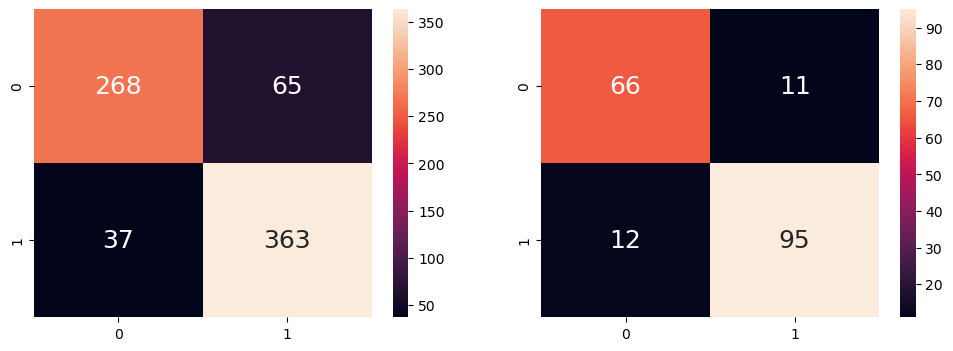

Train Data
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       333
           1       0.85      0.91      0.88       400

    accuracy                           0.86       733
   macro avg       0.86      0.86      0.86       733
weighted avg       0.86      0.86      0.86       733


---------------------------------------------
Test Data
              precision    recall  f1-score   support

           0       0.85      0.86      0.85        77
           1       0.90      0.89      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184




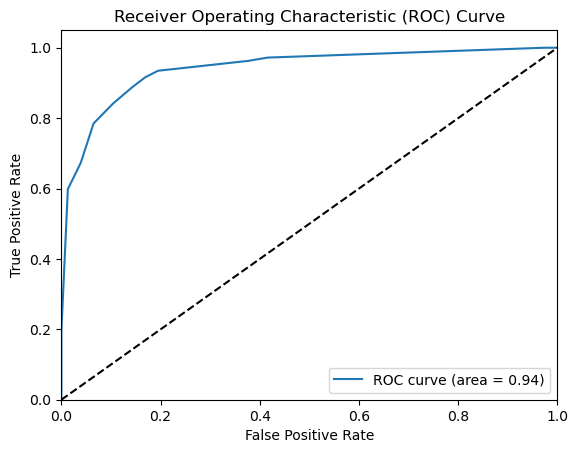

ROC-AUC Score: 0.9401626410972206


In [9]:
DT_DF = main_heart_df.copy()
Best_Decision_Tree_Model_process(DT_DF)

### Best Random Forest Model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Oldpeak            917 non-null    float64
 1   ChestPainType_ASY  917 non-null    float64
 2   Sex_F              917 non-null    float64
 3   ST_Slope_Up        917 non-null    float64
 4   ExerciseAngina_N   917 non-null    float64
 5   HeartDisease       917 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 43.1 KB

Best estimator for Number of Trees:	 100
Best estimator for Max Depth:		 3
0.8662487375695693


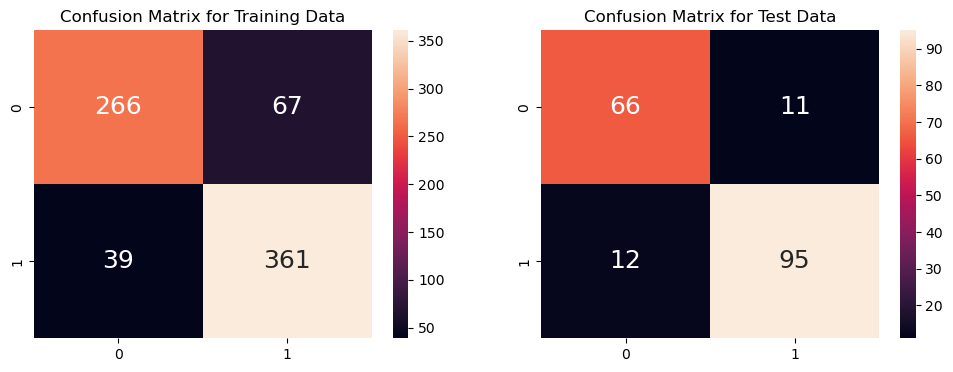

Classification Report

Train Data
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       333
           1       0.84      0.90      0.87       400

    accuracy                           0.86       733
   macro avg       0.86      0.85      0.85       733
weighted avg       0.86      0.86      0.85       733

---------------------------------------------

Test Data
              precision    recall  f1-score   support

           0       0.85      0.86      0.85        77
           1       0.90      0.89      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184




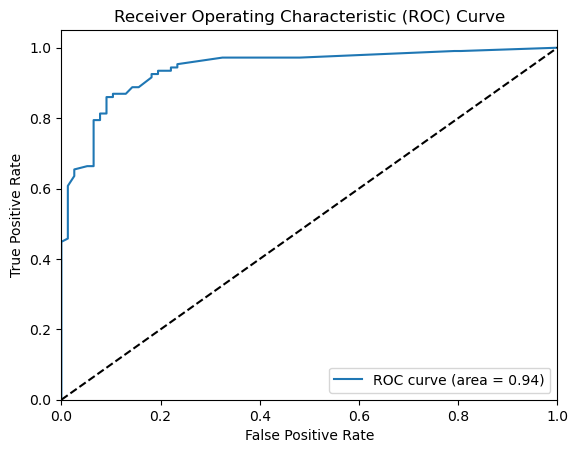

ROC-AUC Score: 0.9408301978395436


In [10]:
# Using the best imputation for this model
RF_DF = main_heart_df.copy()
Best_Random_Forest_Model_process(RF_DF)

### Best Logistic Regression Model


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Oldpeak            917 non-null    float64
 1   ChestPainType_ASY  917 non-null    float64
 2   Sex_F              917 non-null    float64
 3   ST_Slope_Up        917 non-null    float64
 4   ExerciseAngina_N   917 non-null    float64
 5   HeartDisease       917 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 43.1 KB

Best hyperparameters: {'C': 10}
Training set accuracy: 0.8660509150681299



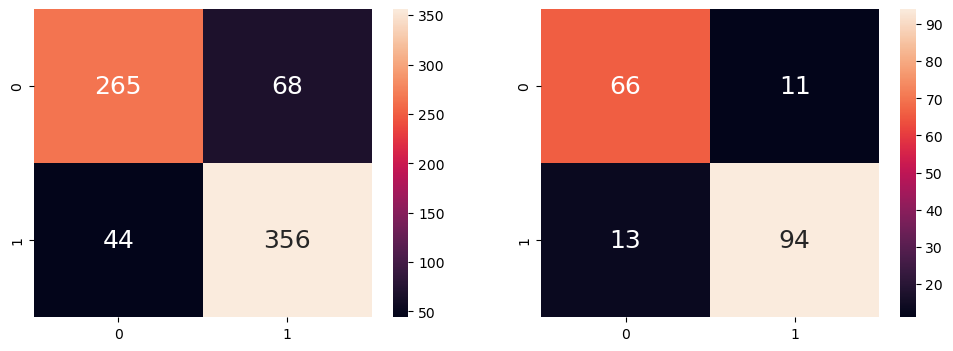

Goodness of Fit of Model (Train Dataset)

Accuracy: 0.8472032742155525

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       333
           1       0.84      0.89      0.86       400

    accuracy                           0.85       733
   macro avg       0.85      0.84      0.84       733
weighted avg       0.85      0.85      0.85       733

---------------------------------------------

Goodness of Fit of Model (Test Dataset)

Accuracy: 0.8695652173913043

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



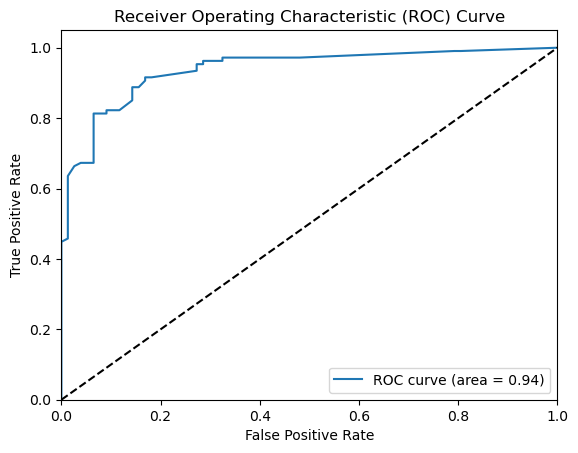

ROC-AUC Score: 0.9378565359873771


In [11]:
# Using the best imputation for this model
LR_DF = main_heart_df.copy()
Best_Logistic_Regression_model_process(LR_DF)

### Best SVM Model


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Oldpeak            917 non-null    float64
 1   ChestPainType_ASY  917 non-null    float64
 2   Sex_F              917 non-null    float64
 3   ST_Slope_Up        917 non-null    float64
 4   ExerciseAngina_N   917 non-null    float64
 5   HeartDisease       917 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 43.1 KB
GridSearch CV best score : 0.8716


Parameters that give the best results : 

 {'C': 0.4, 'gamma': 'scale', 'kernel': 'rbf'}


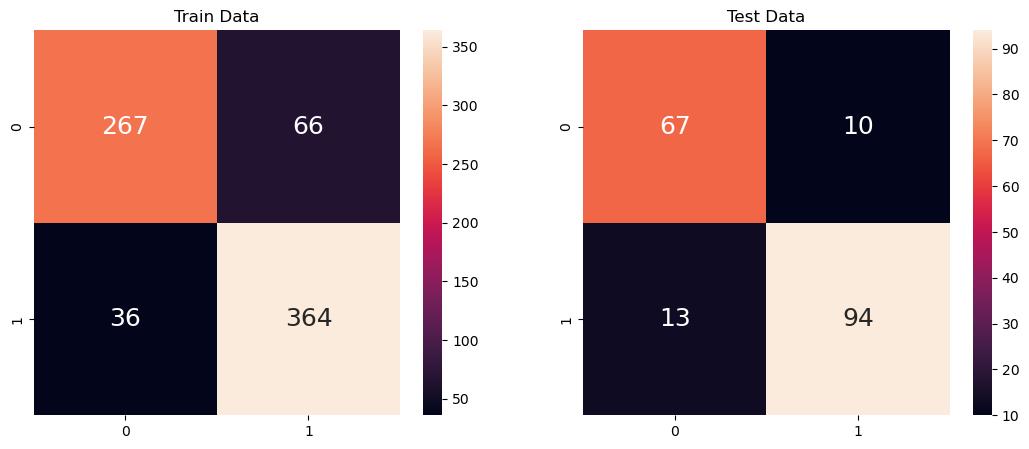

Goodness of Fit of Model (Train Dataset)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       333
           1       0.85      0.91      0.88       400

    accuracy                           0.86       733
   macro avg       0.86      0.86      0.86       733
weighted avg       0.86      0.86      0.86       733


---------------------------------------------

Goodness of Fit of Model (Test Dataset)

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184




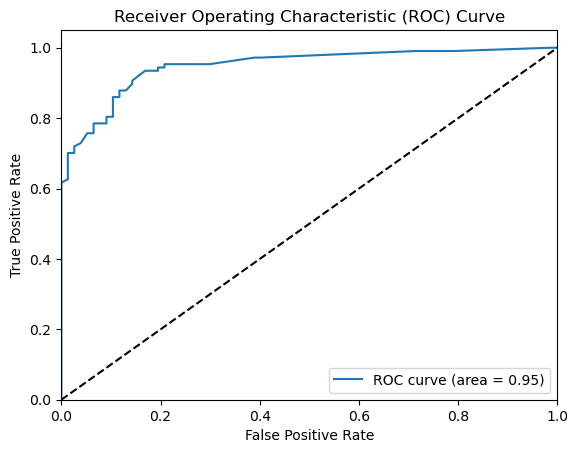

ROC-AUC Score: 0.9481733220050977


In [12]:
# Using the best imputation for this model
SVM_DF = main_heart_df.copy()
Best_SVM_model_process(SVM_DF)

## Classification Report Across All Models

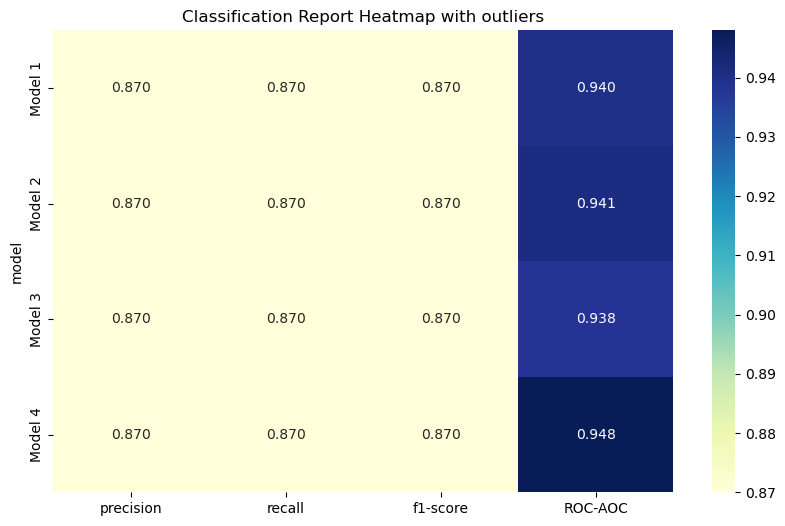

In [16]:
# create a list of all the classification reports

reports = [
    {'model': 'Model 1', 'precision': 0.87, 'recall': 0.87, 'f1-score': 0.87, 'ROC-AOC': 0.940},
    {'model': 'Model 2', 'precision': 0.87, 'recall': 0.87, 'f1-score': 0.87, 'ROC-AOC': 0.941},
    {'model': 'Model 3', 'precision': 0.87, 'recall': 0.87, 'f1-score': 0.87, 'ROC-AOC': 0.938},
    {'model': 'Model 4', 'precision': 0.87, 'recall': 0.87, 'f1-score': 0.87, 'ROC-AOC': 0.948},
]

# create a dataframe from the classification reports
df = pd.DataFrame(reports)

# set the model column as the index
df.set_index('model', inplace=True)

# create a heatmap using seaborn
plt.figure(figsize=(10,6))
sb.heatmap(df, cmap='YlGnBu', annot=True, fmt=".3f")
plt.title('Classification Report Heatmap with outliers')
plt.show()

MODEL 1 : Random Forest Model

MODEL 2 : Decision Tree Model 

MODEL 3 : Logistic Regression Model

MODEL 4 : SVM Model

### Observation:

**It seems that all four models have the same precision , recall and F1 score**. Hence there is a need for another metric, the ROC-AOC score to Certainly prove which is the best model. 

### Explanation:

Using ROC-AUC in addition to other metrics, such as F1 score, can provide a more comprehensive evaluation of the models' performance, especially in cases where the models have similar F1 scores.

ROC-AUC measures the area under the curve of the Receiver Operating Characteristic (ROC) curve, which plots the true positive rate against the false positive rate for different thresholds of the classification algorithm.

If all the models have the same precision, recall, and F1 score, it means that their true positive rates and false positive rates are similar. However, their **ROC curves could still be different, and the area under the curve can indicate which model performs better overall in terms of its ability to distinguish between positive and negative samples.**

Therefore, by comparing the ROC-AUC scores of the models, it is evident that the SVM model that performs better at distinguishing between positive and negative samples, even if all models have the same precision, recall, and F1 score.

### Model Evaluation:

Although the models also had similar ROC-AOC score, the **SVM Model was the one with the highest ROC-AOC score of 0.948**.



## Final Conclusion

In conclusion, this project successfully achieved its objective of identifying the key features or symptoms that determine the likelihood of heart disease in patients. The evaluation of different models using various metrics, including precision, recall, F1 score, and ROC-AUC score, revealed that the SVM model had the highest ROC-AUC score of 0.948 (with the other metrics being the same score as the other models), indicating its effectiveness in predicting the likelihood of heart disease in patients.

Further analysis revealed that **'ChestPainType_ASY'**, **'Sex_F'**, **'Oldpeak'**, **'ExerciseAngina_N'**, and **'ST_Slope_Up'** were the most important features for predicting heart disease. These findings can be used to develop more accurate prediction models and aid in the diagnosis and management of heart disease.

Overall, SVM model is recommended for the use in predicting the likelihood of heart disease in patients by considering the key features or symptoms identified in the study. Further research can be conducted to validate the findings and improve the accuracy of the model, thereby advancing the field of heart disease diagnosis and management.